In [1]:
! pip install vizdoom 
! pip install gym
! pip install "shimmy>=2.0" 
! pip install wandb

import shimmy

from stable_baselines3 import PPO,DQN, A2C
from vizdoom import *
import random #for action sampling
import time #to know how fast training and everything happens
import numpy as np #for identity matrix
from torch.distributions import Categorical

import torch.nn as nn
import torch
#spaces:to define the shapes from our environment :box,discrete box
from gym import Env
from gym.spaces import Discrete, Box
import cv2 # for grayscaling the observation

import matplotlib.pyplot as plt
import os
from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common.evaluation import evaluate_policy

import wandb
wandb.login()  

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")




wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: 21pd18 to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


BASIC

In [2]:
class VizDoomGym(Env):
    def __init__(self,render=False): #wt we need for starting our game
        super().__init__()#to inherit from base class Env
        self.game=DoomGame()
        self.game.load_config('ViZDoom/scenarios/basic.cfg')
        
        if render==False:
            self.game.set_window_visible(False)
        else:
            self.game.set_window_visible(True)
        
        self.game.init() 
        #self.observation_space=Box(low=0,high=255,shape=(240,320,3),dtype=np.uint8)
        self.observation_space=Box(low=0,high=255,shape=(100,160,1),dtype=np.uint8)
        self.action_space=Discrete(3)
        
    def step(self,action): #to take a specific action and take step in the environment
        actions=np.identity(3,dtype=np.uint8)
        reward=self.game.make_action(actions[action],2)
        if self.game.get_state():
            state=self.game.get_state()
            img=state.screen_buffer
            img=self.grayscale(img)
            ammo=state.game_variables[0]
            info={"info":ammo}
        else:
            img=np.zeros(self.observation_space.shape)
            val=0
            info={"info":val}
        done=self.game.is_episode_finished()
        return img,reward,done,info
    def render(self):#define how to render the game
       pass
    
    def reset(self):#when we start a new game
        self.game.new_episode()
        state=self.game.get_state()
        img=state.screen_buffer
        return self.grayscale(img)
    def grayscale(self,observation):
        gray=cv2.cvtColor(np.moveaxis(observation,0,-1),cv2.COLOR_BGR2GRAY)#to make it 240,320,3
        resize=cv2.resize(gray,(160,100),interpolation=cv2.INTER_CUBIC)
        state=np.reshape(resize,(100,160,1))
        return state
    def close(self):#to close the game
        self.game.close()

#### To see how the game looks 

In [ ]:
game=DoomGame()
game.load_config("ViZDoom/scenarios/basic.cfg")
game.init()

(100, 160, 1)


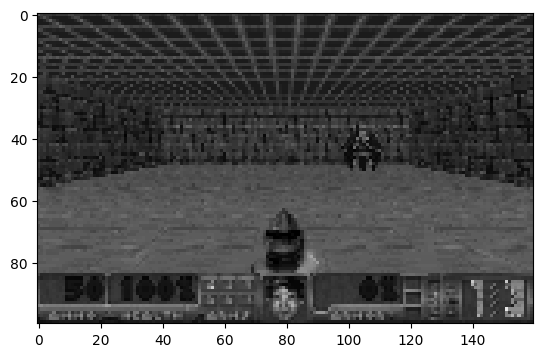

In [3]:
#to check if it is crt
env=VizDoomGym(True)
state=env.reset()
print(state.shape)

plt.imshow(cv2.cvtColor(state,cv2.COLOR_BGR2RGB))

In [ ]:
actions=np.identity(3,dtype=np.uint8) #move left,right and attack
episodes=3 
for ep in range(episodes):#for each ep
    game.new_episode()
    while not game.is_episode_finished(): #not killed opponent or it is timeout 300 steps"""
        state=game.get_state()
        img=state.screen_buffer #get game img 
        info=state.game_variables # 50 -ammo
        reward=game.make_action(random.choice(actions),2)#frame skip to view the moment when bullet hits the monster more quickly
        print('reward:',reward)
        time.sleep(0.02)
    print('Total reward G:',game.get_total_reward())
    time.sleep(2)
        



In [4]:
env.step(2)


(array([[[88],
         [63],
         [55],
         ...,
         [56],
         [89],
         [67]],
 
        [[39],
         [55],
         [79],
         ...,
         [69],
         [39],
         [27]],
 
        [[27],
         [27],
         [35],
         ...,
         [27],
         [27],
         [27]],
 
        ...,
 
        [[50],
         [63],
         [56],
         ...,
         [47],
         [67],
         [52]],
 
        [[15],
         [41],
         [47],
         ...,
         [57],
         [64],
         [47]],
 
        [[17],
         [15],
         [17],
         ...,
         [38],
         [31],
         [27]]], shape=(100, 160, 1), dtype=uint8),
 -2.0,
 False,
 {'info': np.float64(50.0)})

In [5]:
env.close()

In [6]:
! pip install -U pip setuptools wheel
! pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118 --progress-bar on
! pip install stable-baselines3[extra]


  Using cached pip-25.0.1-py3-none-any.whl.metadata (3.7 kB)
  Using cached setuptools-78.1.0-py3-none-any.whl.metadata (6.6 kB)
  Using cached wheel-0.45.1-py3-none-any.whl.metadata (2.3 kB)
Using cached pip-25.0.1-py3-none-any.whl (1.8 MB)
Using cached setuptools-78.1.0-py3-none-any.whl (1.3 MB)
Using cached wheel-0.45.1-py3-none-any.whl (72 kB)


ERROR: To modify pip, please run the following command:
C:\Users\ADMIN\miniconda3\python.exe -m pip install -U pip setuptools wheel


Looking in indexes: https://download.pytorch.org/whl/cu118


#### Checkpoints 

In [9]:
class TrainAndLoggingCallback(BaseCallback):

    def __init__(self, check_freq, save_path, verbose=1):
        super(TrainAndLoggingCallback, self).__init__(verbose)
        self.check_freq = check_freq
        self.save_path = save_path

    def _init_callback(self):
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)

    def _on_step(self):
        if self.n_calls % self.check_freq == 0:
            model_path = os.path.join(self.save_path, 'best_model_{}'.format(self.n_calls))
            self.model.save(model_path)

        return True



#### Train

PPO

In [ ]:
CHECKPOINT_DIR='./train/train_basic_PPO'
LOG_DIR='./logs/log_basic_PPO'

callback=TrainAndLoggingCallback(check_freq=10000,save_path=CHECKPOINT_DIR)
env = VizDoomGym()
model = PPO('CnnPolicy', env, tensorboard_log=LOG_DIR, verbose=1, learning_rate=0.0001, n_steps=2048)
model.learn(total_timesteps=100000,callback=callback)


Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env in a VecTransposeImage.


c:\Users\ADMIN\miniconda3\Lib\site-packages\stable_baselines3\common\vec_env\patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


Logging to ./logs/log_basic\PPO_9
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 40.1     |
|    ep_rew_mean     | -13.5    |
| time/              |          |
|    fps             | 26       |
|    iterations      | 1        |
|    time_elapsed    | 78       |
|    total_timesteps | 2048     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 40.4        |
|    ep_rew_mean          | -13.8       |
| time/                   |             |
|    fps                  | 22          |
|    iterations           | 2           |
|    time_elapsed         | 180         |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.008770394 |
|    clip_fraction        | 0.0841      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.09       |
|    explained_variance   | -8.11e-06 

KeyboardInterrupt: 

In [ ]:

model=PPO.load('./train/train_basic_PPO/best_model_60000')
env=VizDoomGym(True)
mean_reward,std_reward=evaluate_policy(model,env,n_eval_episodes=10)
print(mean_reward)
for ep in range(5):
    obs=env.reset()
    done=False
    total_reward=0
    while not done:
        action,_ = model.predict(obs)
        obs, reward, done, info = env.step(action)
        time.sleep(0.20)
        total_reward+=reward
    print("Total reward for episode {} is {}".format(total_reward,ep))
    time.sleep(2)

#### Hardcode of PPO for basic.cfg

In [ ]:
class ActorCritic(nn.Module):
    def __init__(self, input_dims, n_actions):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 32, 8, stride=4), nn.ReLU(),
            nn.Conv2d(32, 64, 4, stride=2), nn.ReLU(),
            nn.Conv2d(64, 64, 3, stride=1), nn.ReLU()
        )
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 9 * 16, 512), nn.ReLU()
        )
        self.actor = nn.Linear(512, n_actions)
        self.critic = nn.Linear(512, 1)

    def forward(self, x):
        x = x.float() / 255.0
        x = x.permute(0, 3, 1, 2)  # NHWC to NCHW
        x = self.conv(x)
        x = self.fc(x)
        return self.actor(x), self.critic(x)

# 3. PPO Agent
class PPOAgent:
    def __init__(self, env, gamma=0.99, lam=0.95, clip=0.2, lr=1e-4):
        self.env = env
        self.gamma = gamma
        self.lam = lam
        self.clip = clip
        self.model = ActorCritic(env.observation_space.shape, env.action_space.n).to(device)
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=lr)

    def get_action(self, state):
        state = torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(device)
        logits, _ = self.model(state)
        dist = Categorical(logits=logits)
        action = dist.sample()
        return action.item(), dist.log_prob(action), dist.entropy()

    def compute_advantages(self, rewards, values, dones):
        advantages, gae = [], 0
        for i in reversed(range(len(rewards))):
            delta = rewards[i] + self.gamma * values[i + 1] * (1 - dones[i]) - values[i]
            gae = delta + self.gamma * self.lam * (1 - dones[i]) * gae
            advantages.insert(0, gae)
        return advantages

    def update(self, trajectory):
        states = torch.tensor(np.array(trajectory["states"]), dtype=torch.float32).to(device)
        actions = torch.tensor(trajectory["actions"]).to(device)
        old_log_probs = torch.tensor(trajectory["log_probs"]).to(device)
        returns = torch.tensor(trajectory["returns"]).to(device)
        advantages = torch.tensor(trajectory["advantages"]).to(device)

        for _ in range(4):  # epochs
            logits, values = self.model(states)
            dist = Categorical(logits=logits)
            new_log_probs = dist.log_prob(actions)
            ratio = (new_log_probs - old_log_probs).exp()

            surrogate1 = ratio * advantages
            surrogate2 = torch.clamp(ratio, 1 - self.clip, 1 + self.clip) * advantages
            actor_loss = -torch.min(surrogate1, surrogate2).mean()
            critic_loss = (returns - values.squeeze()).pow(2).mean()

            loss = actor_loss + 0.5 * critic_loss

            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()

# 4. Training loop
def train(env, agent, timesteps=100000, rollout_len=2048, save_path="./train/train_basic_PPO/ppo_vizdoom_best.pt"):
    best_reward = -np.inf
    all_rewards = []

    state = env.reset()
    episode_reward = 0
    trajectory = {"states": [], "actions": [], "log_probs": [], "rewards": [], "values": [], "dones": []}

    for t in range(1, timesteps + 1):
        action, log_prob, _ = agent.get_action(state)
        with torch.no_grad():
            _, value = agent.model(torch.tensor(state).unsqueeze(0).to(device).float())
        value = value.item()

        next_state, reward, done, _ = env.step(action)

        trajectory["states"].append(state)
        trajectory["actions"].append(action)
        trajectory["log_probs"].append(log_prob.item())
        trajectory["rewards"].append(reward)
        trajectory["values"].append(value)
        trajectory["dones"].append(done)

        state = next_state
        episode_reward += reward

        if done:
            state = env.reset()
            all_rewards.append(episode_reward)
            print(f"Episode done | Total reward: {episode_reward}")
            if episode_reward > best_reward:
                best_reward = episode_reward
                torch.save(agent.model.state_dict(), save_path)
                print(f"New best model saved with reward: {best_reward}")
            episode_reward = 0

        if t % rollout_len == 0:
            _, value = agent.model(torch.tensor(state).unsqueeze(0).to(device).float())
            value = value.detach().item()
            trajectory["values"].append(value)
            advantages = agent.compute_advantages(trajectory["rewards"], trajectory["values"], trajectory["dones"])
            returns = [adv + val for adv, val in zip(advantages, trajectory["values"][:-1])]
            trajectory["returns"] = returns
            trajectory["advantages"] = advantages

            agent.update(trajectory)
            trajectory = {"states": [], "actions": [], "log_probs": [], "rewards": [], "values": [], "dones": []}
    env.close()
    return all_rewards

def evaluate(model_path, episodes=5, render=True):
    env = VizDoomGym(render=render)
    model = ActorCritic(env.observation_space.shape, env.action_space.n).to(device)
    model.load_state_dict(torch.load(model_path))
    model.eval()

    for ep in range(episodes):
        state = env.reset()
        done = False
        total_reward = 0
        while not done:
            with torch.no_grad():
                state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(device)
                logits, _ = model(state_tensor)
                action = torch.argmax(logits, dim=-1).item()
            state, reward, done, _ = env.step(action)
            total_reward += reward
            if render:
                cv2.imshow("ViZDoom", np.squeeze(state))
                cv2.waitKey(10)
        print(f"Episode {ep + 1} finished with total reward: {total_reward}")
    env.close()
    cv2.destroyAllWindows()

# 5. Run training
env = VizDoomGym(render=False)
agent = PPOAgent(env)
train(env, agent, timesteps=50000)


In [ ]:
evaluate("./train/train_basic_PPO/ppo_vizdoom_best.pt", episodes=5, render=True)


In [ ]:
evaluate("./train/train_basic_PPO/ppo_vizdoom_best_2.pt", episodes=5, render=True)


DQN

In [ ]:
CHECKPOINT_DIR='./train/train_basic_DQN'
LOG_DIR='./logs/log_basic_DQN'

callback=TrainAndLoggingCallback(check_freq=10000,save_path=CHECKPOINT_DIR)
model_dqn = DQN('CnnPolicy', env, verbose=1, tensorboard_log=LOG_DIR, verbose=1, learning_rate=0.0001, n_steps=2048)
model_dqn.learn(total_timesteps=60000,callback=callback)


In [ ]:

model=PPO.load('./train/train_basic_DQN/best_model_60000')
env=VizDoomGym(True)
mean_reward,std_reward=evaluate_policy(model,env,n_eval_episodes=10)
print(mean_reward)
for ep in range(5):
    obs=env.reset()
    done=False
    total_reward=0
    while not done:
        action,_ = model.predict(obs)
        obs, reward, done, info = env.step(action)
        time.sleep(0.20)
        total_reward+=reward
    print("Total reward for episode {} is {}".format(total_reward,ep))
    time.sleep(2)

A2C

In [ ]:
CHECKPOINT_DIR='./train/train_basic_A2C'
LOG_DIR='./logs/log_basic_A2C'

callback=TrainAndLoggingCallback(check_freq=10000,save_path=CHECKPOINT_DIR)
model_a2c = A2C('CnnPolicy', env, verbose=1, tensorboard_log=LOG_DIR, verbose=1, learning_rate=0.0001, n_steps=2048)
model_a2c.learn(total_timesteps=60000,callback=callback)


#### Test or evaluate model

In [ ]:

model=PPO.load('./train/train_basic_A2C/best_model_60000')
env=VizDoomGym(True)
mean_reward,std_reward=evaluate_policy(model,env,n_eval_episodes=10)
print(mean_reward)
for ep in range(5):
    obs=env.reset()
    done=False
    total_reward=0
    while not done:
        action,_ = model.predict(obs)
        obs, reward, done, info = env.step(action)
        time.sleep(0.20)
        total_reward+=reward
    print("Total reward for episode {} is {}".format(total_reward,ep))
    time.sleep(2)

c:\Users\ADMIN\miniconda3\Lib\site-packages\stable_baselines3\common\vec_env\patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(
c:\Users\ADMIN\miniconda3\Lib\site-packages\stable_baselines3\common\evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


48.4
Total reward for episode 95.0 is 0
Total reward for episode 95.0 is 1
Total reward for episode -300.0 is 2
Total reward for episode -300.0 is 3
Total reward for episode 95.0 is 4


METRIC

In [3]:
models = {
    'PPO': PPO.load('./train/train_basic_PPO/best_model_60000'),
    'DQN': DQN.load('./train/train_basic_DQN/best_model_60000'),
    'A2C': A2C.load('./train/train_basic_A2C/best_model_60000')
}

c:\Users\ADMIN\miniconda3\Lib\site-packages\stable_baselines3\common\save_util.py:167: UserWarning: Could not deserialize object lr_schedule. Consider using `custom_objects` argument to replace this object.
Exception: code() argument 13 must be str, not int
  warnings.warn(
c:\Users\ADMIN\miniconda3\Lib\site-packages\stable_baselines3\common\save_util.py:167: UserWarning: Could not deserialize object exploration_schedule. Consider using `custom_objects` argument to replace this object.
Exception: code() argument 13 must be str, not int
  warnings.warn(


In [ ]:
models = {
    'PPO': PPO.load('./train/train_basic_PPO/best_model_60000'),
    'DQN': DQN.load('./train/train_basic_DQN/best_model_60000'),
    'A2C': A2C.load('./train/train_basic_A2C/best_model_60000')
}

for name, model in models.items():
    env=VizDoomGym(True)
    for ep in range(5):
        obs=env.reset()
        done=False
        total_reward=0
        while not done:
            action,_ = model.predict(obs)
            obs, reward, done, info = env.step(action)
            time.sleep(0.20)
            total_reward+=reward
        print("Total reward for episode {} is {}".format(total_reward,ep))
        time.sleep(2)
    mean_reward, _ = evaluate_policy(model, env, n_eval_episodes=2)
    print(f"{name} - Mean Reward: {mean_reward:.2f} | Std: {std_reward:.2f}")

Total reward for episode -300.0 is 0
Total reward for episode 77.0 is 1
Total reward for episode 89.0 is 2
Total reward for episode 24.0 is 3
Total reward for episode 93.0 is 4


c:\Users\ADMIN\miniconda3\Lib\site-packages\stable_baselines3\common\vec_env\patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(
c:\Users\ADMIN\miniconda3\Lib\site-packages\stable_baselines3\common\evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


PPO - Mean Reward: -300.00 | Std: 0.00
Total reward for episode 85.0 is 0
Total reward for episode -310.0 is 1
Total reward for episode 95.0 is 2
Total reward for episode -300.0 is 3
Total reward for episode 85.0 is 4
DQN - Mean Reward: 85.00 | Std: 0.00


In [4]:
import time
import matplotlib.pyplot as plt

episode_rewards = {}  # to store rewards per episode for each model

for name, model in models.items():
    env = VizDoomGym(True)
    rewards = []
    for ep in range(5):
        obs = env.reset()
        done = False
        total_reward = 0
        while not done:
            action, _ = model.predict(obs)
            obs, reward, done, info = env.step(action)
            time.sleep(0.20)
            total_reward += reward
        print(f"{name} - Total reward for episode {ep + 1} is {total_reward}")
        rewards.append(total_reward)
        time.sleep(2)

    episode_rewards[name] = rewards


PPO - Total reward for episode 1 is 93.0
PPO - Total reward for episode 2 is -300.0
PPO - Total reward for episode 3 is 95.0
PPO - Total reward for episode 4 is 95.0
PPO - Total reward for episode 5 is 95.0
DQN - Total reward for episode 1 is -310.0
DQN - Total reward for episode 2 is 85.0
DQN - Total reward for episode 3 is 85.0
DQN - Total reward for episode 4 is -320.0
DQN - Total reward for episode 5 is -300.0
A2C - Total reward for episode 1 is 95.0
A2C - Total reward for episode 2 is 95.0
A2C - Total reward for episode 3 is 95.0
A2C - Total reward for episode 4 is -410.0
A2C - Total reward for episode 5 is 95.0


  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)


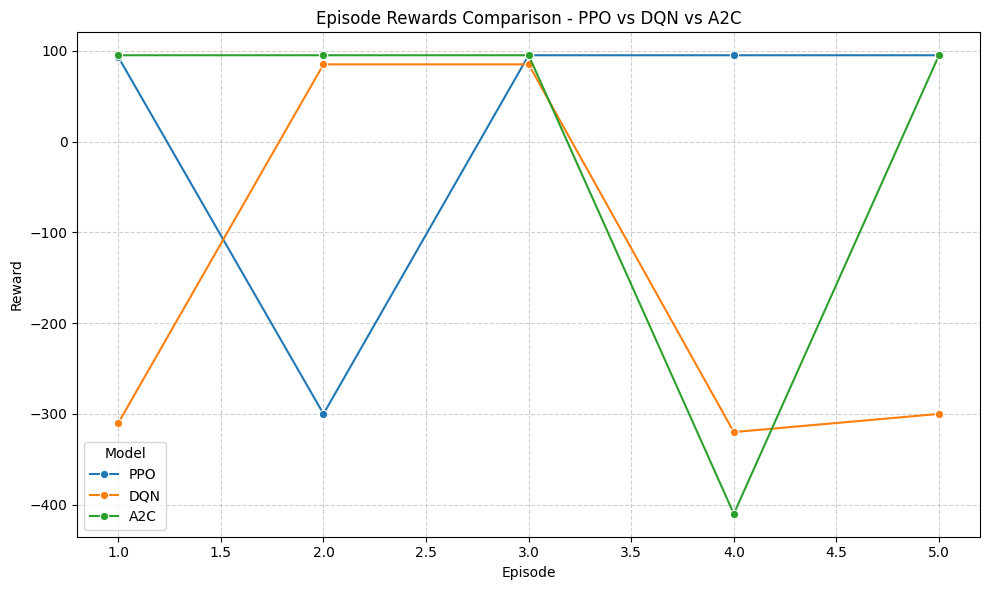

In [5]:
! pip install seaborn
import seaborn as sns
import pandas as pd

# Prepare DataFrame for seaborn
data = []
for model, rewards in episode_rewards.items():
    for ep_num, reward in enumerate(rewards, start=1):
        data.append({'Model': model, 'Episode': ep_num, 'Reward': reward})

df = pd.DataFrame(data)

# Plot
plt.figure(figsize=(10, 6))
sns.lineplot(data=df, x='Episode', y='Reward', hue='Model', marker='o', palette='tab10')
plt.title('Episode Rewards Comparison - PPO vs DQN vs A2C')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


## DEFEND CENTER

In [8]:
#define vizdppm openai environment class

class VizDoomGym(Env):
    def __init__(self,render=False): #wt we need for starting our game
        super().__init__()#to inherit from base class Env
        self.game=DoomGame()
        self.game.load_config('ViZDoom/scenarios/defend_the_center.cfg')
        
        if render==False:
            self.game.set_window_visible(False)
        else:
            self.game.set_window_visible(True)
        
        self.game.init() 
        #self.observation_space=Box(low=0,high=255,shape=(240,320,3),dtype=np.uint8)
        self.observation_space=Box(low=0,high=255,shape=(100,160,1),dtype=np.uint8)
        self.action_space=Discrete(3)
        
    def step(self,action): #to take a specific action and take step in the environment
        actions=np.identity(3,dtype=np.uint8)
        reward=self.game.make_action(actions[action],4)
        if self.game.get_state():
            state=self.game.get_state()
            img=state.screen_buffer
            img=self.grayscale(img)
            ammo=state.game_variables[0]
            info={"info":ammo}
        else:
            img=np.zeros(self.observation_space.shape)
            val=0
            info={"info":val}
        done=self.game.is_episode_finished()
        return img,reward,done,info
    def render(self):#define how to render the game
       pass
    
    def reset(self):#when we start a new game
        self.game.new_episode()
        state=self.game.get_state()
        img=state.screen_buffer
        return self.grayscale(img)
    def grayscale(self,observation):
        gray=cv2.cvtColor(np.moveaxis(observation,0,-1),cv2.COLOR_BGR2GRAY)#to make it 240,320,3
        resize=cv2.resize(gray,(160,100),interpolation=cv2.INTER_CUBIC)
        state=np.reshape(resize,(100,160,1))
        return state
    def close(self):#to close the game
        self.game.close()


#### To see how the game looks 

In [1]:
game=DoomGame()
game.load_config("ViZDoom/scenarios/defend_the_center.cfg")
game.init()

NameError: name 'DoomGame' is not defined

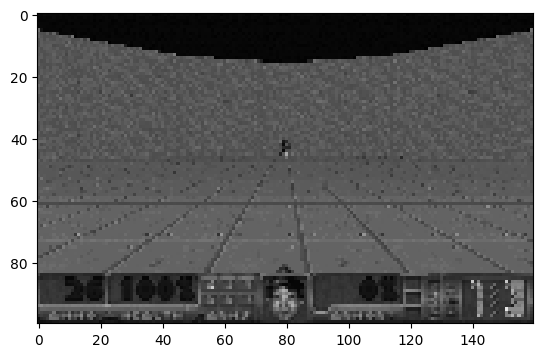

In [9]:
env=VizDoomGym(True)
state=env.reset()
plt.imshow(cv2.cvtColor(state,cv2.COLOR_BGR2RGB))
env.close()


In [ ]:
actions=np.identity(3,dtype=np.uint8) #move left,right and attack
episodes=3 
for ep in range(episodes):#for each ep
    game.new_episode()
    while not game.is_episode_finished(): #not killed opponent or it is timeout 300 steps"""
        state=game.get_state()
        img=state.screen_buffer #get game img 
        info=state.game_variables # 50 -ammo
        reward=game.make_action(random.choice(actions),2)#frame skip to view the moment when bullet hits the monster more quickly
        print('reward:',reward)
        time.sleep(0.02)
    print('Total reward G:',game.get_total_reward())
    time.sleep(2)
        


#### Train 

In [12]:
CHECKPOINT_DIR='./train/train_defend'
LOG_DIR='./logs/log_defend'

callback=TrainAndLoggingCallback(check_freq=10000,save_path=CHECKPOINT_DIR)

env=VizDoomGym()
model=PPO('CnnPolicy',env,tensorboard_log=LOG_DIR,verbose=1,learning_rate=0.0001,n_steps=4096)
model.learn(total_timesteps=100000,callback=callback)

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env in a VecTransposeImage.
Logging to ./logs/log_defend\PPO_2
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 82.9     |
|    ep_rew_mean     | 0.327    |
| time/              |          |
|    fps             | 9        |
|    iterations      | 1        |
|    time_elapsed    | 437      |
|    total_timesteps | 4096     |
---------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 83           |
|    ep_rew_mean          | 0.245        |
| time/                   |              |
|    fps                  | 10           |
|    iterations           | 2            |
|    time_elapsed         | 744          |
|    total_timesteps      | 8192         |
| train/                  |              |
|    approx_kl            | 0.0090697035 |
|    clip_fractio

#### Test or evaluate model

In [13]:
model=PPO.load('./train/train_defend/best_model_100000')
env=VizDoomGym(True)
mean_reward,_=evaluate_policy(model,env,n_eval_episodes=10)
print(mean_reward)
for ep in range(5):
    obs=env.reset()
    done=False
    total_reward=0
    while not done:
        action,_ = model.predict(obs)
        obs, reward, done, info = env.step(action)
        time.sleep(0.20)
        total_reward+=reward
    print("Total reward for episode {} is {}".format(total_reward,ep))
    time.sleep(2)

6.4
Total reward for episode 10.0 is 0
Total reward for episode 11.0 is 1
Total reward for episode 6.0 is 2
Total reward for episode 11.0 is 3
Total reward for episode 8.0 is 4


## DEADLY CORRIDOR


#### To see how the game looks 

In [2]:
game=DoomGame()
game.load_config("ViZDoom/scenarios/deadly_corridor.cfg")
game.init()

### Curriculum Learning

#### Comparing how level 1 and level 3 looks like

In [ ]:
game=DoomGame()
game.load_config("ViZDoom/scenarios/deadly_corridor_s1.cfg")
game.init()


reward: 0.0
reward: 0.0
reward: 0.0
reward: 0.0
reward: 0.0
reward: 0.0
reward: 2.26934814453125
reward: 2.6382293701171875
reward: 2.12066650390625
reward: 1.7207794189453125
reward: -0.8474884033203125
reward: -1.4010162353515625
reward: -1.150665283203125
reward: 1.324310302734375
reward: 1.8621063232421875
reward: 1.6169586181640625
reward: 1.348785400390625
reward: 1.1077117919921875
reward: 0.8569488525390625
reward: 2.9511260986328125
reward: 3.1313629150390625
reward: 2.3424224853515625
reward: 1.67352294921875
reward: -0.833740234375
reward: -1.014190673828125
reward: -1.0602569580078125
reward: -0.64166259765625
reward: -0.4232025146484375
reward: -0.34759521484375
reward: 1.9580535888671875
reward: -0.3402252197265625
reward: -2.3004608154296875
reward: -1.99322509765625
reward: -1.63702392578125
reward: -1.3444976806640625
reward: 1.1651153564453125
reward: 1.6645355224609375
reward: 1.3670501708984375
reward: -1.138153076171875
reward: -1.441162109375
reward: -0.9230651855

In [ ]:
actions=np.identity(7,dtype=np.uint8) #move left,right and attack
episodes=3 
for ep in range(episodes):#for each ep
    game.new_episode()
    while not game.is_episode_finished(): #not killed opponent or it is timeout 300 steps"""
        state=game.get_state()
        img=state.screen_buffer #get game img 
        info=state.game_variables # 50 -ammo
        reward=game.make_action(random.choice(actions),2)#frame skip to view the moment when bullet hits the monster more quickly
        print('reward:',reward)
        time.sleep(0.02)
    print('Total reward G:',game.get_total_reward())
    time.sleep(2)

In [12]:
game=DoomGame()
game.load_config("ViZDoom/scenarios/deadly_corridor_s3.cfg")
game.init()

In [8]:
actions=np.identity(7,dtype=np.uint8) #move left,right and attack
episodes=3 
for ep in range(episodes):#for each ep
    game.new_episode()
    while not game.is_episode_finished(): #not killed opponent or it is timeout 300 steps"""
        state=game.get_state()
        img=state.screen_buffer #get game img 
        info=state.game_variables # 50 -ammo
        reward=game.make_action(random.choice(actions),2)#frame skip to view the moment when bullet hits the monster more quickly
        print('reward:',reward)
        time.sleep(0.02)
    print('Total reward G:',game.get_total_reward())
    time.sleep(2)
        



reward: 0.0
reward: 0.0
reward: 0.0
reward: 0.78125
reward: 1.349639892578125
reward: 1.1084136962890625
reward: 0.910308837890625
reward: 1.014404296875
reward: -1.3369140625
reward: 0.4525299072265625
reward: 1.0742340087890625
reward: 0.483245849609375
reward: 2.504241943359375
reward: 2.75262451171875
reward: 2.5274505615234375
reward: -0.0942840576171875
reward: -0.780059814453125
reward: -5.09173583984375
reward: -5.0951995849609375
reward: -0.4068756103515625
reward: -0.4678497314453125
reward: -0.5596160888671875
reward: -3.070098876953125
reward: -2.3461761474609375
reward: 0.3808135986328125
reward: 1.01934814453125
reward: 1.1039276123046875
reward: 0.9897918701171875
reward: 0.8128662109375
reward: 2.8816070556640625
reward: 0.6280364990234375
reward: -0.182952880859375
reward: -0.14727783203125
reward: -0.1209869384765625
reward: -2.3656463623046875
reward: -2.6495819091796875
reward: -99.90989685058594
Total reward G: -101.85041809082031
reward: 0.0
reward: 0.0
reward: 0.

In [13]:
game.get_state().game_variables

array([100.,   0.,   0.,  -1.])

In [7]:
#define vizdppm openai environment class

class VizDoomGym(Env):
    def __init__(self,render=False,config='ViZDoom/scenarios/deadly_corridor_s1.cfg'): #wt we need for starting our game
        super().__init__()#to inherit from base class Env
        self.game=DoomGame()
        self.game.load_config(config)
        
        if render==False:
            self.game.set_window_visible(False)
        else:
            self.game.set_window_visible(True)
        
        self.game.init() 
        #self.observation_space=Box(low=0,high=255,shape=(240,320,3),dtype=np.uint8)
        self.observation_space=Box(low=0,high=255,shape=(100,160,1),dtype=np.uint8)
        self.action_space=Discrete(7)
        
        self.damage_taken = 0
        self.hitcount = 0
        self.ammo = 50
        
    def step(self,action): #to take a specific action and take step in the environment
        actions=np.identity(7,dtype=np.uint8)
        movement_reward = self.game.make_action(actions[action], 2) 
        reward = 0 
        if self.game.get_state():
            state=self.game.get_state()
            img=state.screen_buffer
            img=self.grayscale(img)
            game_variables = self.game.get_state().game_variables
            health, damage_taken, hitcount, ammo = game_variables
            
            # change in damage from previous frames
            damage_taken_delta = -damage_taken + self.damage_taken
            self.damage_taken = damage_taken
            hitcount_delta = hitcount - self.hitcount
            self.hitcount = hitcount
            ammo_delta = ammo - self.ammo
            self.ammo = ammo
            
            reward = movement_reward + damage_taken_delta*10 + hitcount_delta*200  + ammo_delta*5 
            info ={"info":ammo}
        else:
            img=np.zeros(self.observation_space.shape)
            val=0
            info={"info":val}
        done=self.game.is_episode_finished()
        return img,reward,done,info
    def render(self):#define how to render the game
       pass
    
    def reset(self):#when we start a new game
        self.game.new_episode()
        state=self.game.get_state()
        img=state.screen_buffer
        return self.grayscale(img)
    def grayscale(self,observation):
        gray=cv2.cvtColor(np.moveaxis(observation,0,-1),cv2.COLOR_BGR2GRAY)#to make it 240,320,3
        resize=cv2.resize(gray,(160,100),interpolation=cv2.INTER_CUBIC)
        state=np.reshape(resize,(100,160,1))
        return state
    def close(self):#to close the game
        self.game.close()


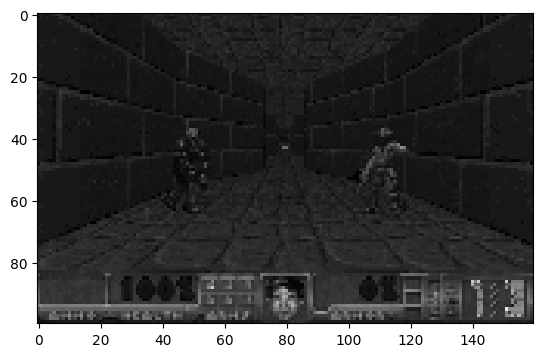

In [ ]:
env=VizDoomGym(True,'ViZDoom/scenarios/deadly_corridor_s1.cfg')
state=env.reset()
plt.imshow(cv2.cvtColor(state,cv2.COLOR_BGR2RGB))
env.close()

#### Train

In [10]:

CHECKPOINT_DIR = './train/train_corridor'
LOG_DIR = './logs/log_corridor'
callback = TrainAndLoggingCallback(check_freq=10000, save_path=CHECKPOINT_DIR)
env = VizDoomGym()
model = PPO('CnnPolicy', env, tensorboard_log=LOG_DIR, verbose=1, learning_rate=0.00001, n_steps=8192, clip_range=.1, gamma=.95, gae_lambda=.9)
model.learn(total_timesteps=40000, callback=callback)


Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env in a VecTransposeImage.


c:\Users\ADMIN\miniconda3\Lib\site-packages\stable_baselines3\common\vec_env\patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


Logging to ./logs/log_corridor\PPO_2
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 376      |
|    ep_rew_mean     | 30.8     |
| time/              |          |
|    fps             | 15       |
|    iterations      | 1        |
|    time_elapsed    | 525      |
|    total_timesteps | 8192     |
---------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 367          |
|    ep_rew_mean          | 91.7         |
| time/                   |              |
|    fps                  | 13           |
|    iterations           | 2            |
|    time_elapsed         | 1174         |
|    total_timesteps      | 16384        |
| train/                  |              |
|    approx_kl            | 0.0032199628 |
|    clip_fraction        | 0.144        |
|    clip_range           | 0.1          |
|    entropy_loss         | -1.94        |
|    explained_varian

In [11]:
model.load('./train/train_corridor/best_model_40000.zip')
env = VizDoomGym(config='VizDoom/scenarios/deadly_corridor_s2.cfg')
model.set_env(env)
model.learn(total_timesteps=40000, callback=callback)

Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env in a VecTransposeImage.
Logging to ./logs/log_corridor\PPO_3


c:\Users\ADMIN\miniconda3\Lib\site-packages\stable_baselines3\common\vec_env\patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 119      |
|    ep_rew_mean     | 144      |
| time/              |          |
|    fps             | 18       |
|    iterations      | 1        |
|    time_elapsed    | 454      |
|    total_timesteps | 8192     |
---------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 106          |
|    ep_rew_mean          | 149          |
| time/                   |              |
|    fps                  | 15           |
|    iterations           | 2            |
|    time_elapsed         | 1055         |
|    total_timesteps      | 16384        |
| train/                  |              |
|    approx_kl            | 0.0024856208 |
|    clip_fraction        | 0.121        |
|    clip_range           | 0.1          |
|    entropy_loss         | -1.88        |
|    explained_variance   | 0.149        |
|    learning_r

In [12]:
env = VizDoomGym(config='VizDoom/scenarios/deadly_corridor_s3.cfg')
model.set_env(env)
model.learn(total_timesteps=40000, callback=callback)

Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env in a VecTransposeImage.
Logging to ./logs/log_corridor\PPO_4
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 143      |
|    ep_rew_mean     | 177      |
| time/              |          |
|    fps             | 18       |
|    iterations      | 1        |
|    time_elapsed    | 442      |
|    total_timesteps | 8192     |
---------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 132          |
|    ep_rew_mean          | 207          |
| time/                   |              |
|    fps                  | 16           |
|    iterations           | 2            |
|    time_elapsed         | 1010         |
|    total_timesteps      | 16384        |
| train/                  |              |
|    approx_kl            | 0.0029752273 |
|    clip_fraction        | 0.20

In [13]:
env = VizDoomGym(config='VizDoom/scenarios/deadly_corridor_s4.cfg')
model.set_env(env)
model.learn(total_timesteps=40000, callback=callback)

Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env in a VecTransposeImage.
Logging to ./logs/log_corridor\PPO_5
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 136      |
|    ep_rew_mean     | 263      |
| time/              |          |
|    fps             | 22       |
|    iterations      | 1        |
|    time_elapsed    | 364      |
|    total_timesteps | 8192     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 140         |
|    ep_rew_mean          | 277         |
| time/                   |             |
|    fps                  | 19          |
|    iterations           | 2           |
|    time_elapsed         | 851         |
|    total_timesteps      | 16384       |
| train/                  |             |
|    approx_kl            | 0.003296552 |
|    clip_fraction        | 0.204       |
|

In [14]:
env = VizDoomGym(config='VizDoom/scenarios/deadly_corridor_s5.cfg')
model.set_env(env)
model.learn(total_timesteps=40000, callback=callback)

Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env in a VecTransposeImage.
Logging to ./logs/log_corridor\PPO_6
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 68.9     |
|    ep_rew_mean     | 131      |
| time/              |          |
|    fps             | 17       |
|    iterations      | 1        |
|    time_elapsed    | 463      |
|    total_timesteps | 8192     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 62.3        |
|    ep_rew_mean          | 125         |
| time/                   |             |
|    fps                  | 13          |
|    iterations           | 2           |
|    time_elapsed         | 1177        |
|    total_timesteps      | 16384       |
| train/                  |             |
|    approx_kl            | 0.007245796 |
|    clip_fraction        | 0.285       |
|

#### Test or evaluate model

In [16]:
env=VizDoomGym(True)
mean_reward, _ = evaluate_policy(model, env, n_eval_episodes=10)
for episode in range(20): 
    obs = env.reset()
    done = False
    total_reward = 0
    while not done: 
        action, _ = model.predict(obs)
        obs, reward, done, info = env.step(action)
        time.sleep(0.02)
        total_reward += reward
    print('Total Reward for episode {} is {}'.format(total_reward, episode))
    time.sleep(2)

Total Reward for episode 673.6828765869141 is 0
Total Reward for episode 365.675537109375 is 1
Total Reward for episode 178.28683471679688 is 2
Total Reward for episode 715.11669921875 is 3
Total Reward for episode -177.1146697998047 is 4
Total Reward for episode 347.4745635986328 is 5
Total Reward for episode 222.09954833984375 is 6
Total Reward for episode 481.0633850097656 is 7
Total Reward for episode 220.78280639648438 is 8
Total Reward for episode 509.1024169921875 is 9
Total Reward for episode 528.16162109375 is 10
Total Reward for episode 500.61370849609375 is 11
Total Reward for episode 191.65017700195312 is 12
Total Reward for episode 385.7401580810547 is 13
Total Reward for episode 381.0421447753906 is 14
Total Reward for episode 583.3527069091797 is 15
Total Reward for episode 83.52415466308594 is 16
Total Reward for episode 883.8873596191406 is 17
Total Reward for episode 4.6851043701171875 is 18
Total Reward for episode 321.6259765625 is 19
